In [25]:
import os
import shutil
import random
from pathlib import Path

# --- 1. Configuration ---
# Define source directories in a dictionary for easy iteration
source_dirs = {
    "sunny": "./data/sunny",
    "cloudy": "./data/cloudy",
    "rainy": "./data/rainy",
    "snowy": "./data/snowy",
    "foggy": "./data/foggy",
}

# Define base destination directories
base_train_dir = Path("./data/weather_train")
base_valid_dir = Path("./data/weather_validation")
base_test_dir = Path("./data/weather_test")

# Define split percentages for train, validation, and test sets
train_pct = 0.70
validation_pct = 0.15
test_pct = 0.15

# --- 2. Setup Directories ---
# Clean and create the directory structure
for base_dir in [base_train_dir, base_valid_dir, base_test_dir]:
    if base_dir.exists():
        shutil.rmtree(base_dir)
    # Create the base directory and all subdirectories for each weather type
    for weather_type in source_dirs.keys():
        os.makedirs(base_dir / weather_type, exist_ok=True)


# --- 3. Split and Copy Files ---
def copy_images(source_path, dest_path, image_files):
    """Copies a list of image files from a source to a destination."""
    for image in image_files:
        shutil.copyfile(source_path / image, dest_path / image)


# Loop through each weather type
for weather_type, source_path_str in source_dirs.items():
    source_path = Path(source_path_str)
    print(f"\nProcessing images for '{weather_type}'...")

    # 1. Get the list of images for the CURRENT category first.
    all_images = os.listdir(source_path)
    random.shuffle(all_images)  # Shuffle the list for a random split.

    # 2. Now, calculate split sizes based on the correct total.
    total_images = len(all_images)
    train_amount = int(total_images * train_pct)
    validation_amount = int(total_images * validation_pct)
    # The rest go to the test set to handle any rounding issues
    test_amount = total_images - train_amount - validation_amount

    # 3. Define non-overlapping slices from the shuffled list.
    train_split = all_images[:train_amount]
    valid_split = all_images[train_amount : train_amount + validation_amount]
    test_split = all_images[train_amount + validation_amount :]

    # Copy files to their respective destinations
    copy_images(source_path, base_train_dir / weather_type, train_split)
    copy_images(source_path, base_valid_dir / weather_type, valid_split)
    copy_images(source_path, base_test_dir / weather_type, test_split)

    print(f"  Total images: {total_images}")
    print(f"  Copied {len(train_split)} images to training set.")
    print(f"  Copied {len(valid_split)} images to validation set.")
    print(f"  Copied {len(test_split)} images to test set.")

print("\nData preparation complete.")


Processing images for 'sunny'...
  Total images: 6274
  Copied 4391 images to training set.
  Copied 941 images to validation set.
  Copied 942 images to test set.

Processing images for 'cloudy'...
  Total images: 6702
  Copied 4691 images to training set.
  Copied 1005 images to validation set.
  Copied 1006 images to test set.

Processing images for 'rainy'...
  Total images: 1927
  Copied 1348 images to training set.
  Copied 289 images to validation set.
  Copied 290 images to test set.

Processing images for 'snowy'...
  Total images: 1875
  Copied 1312 images to training set.
  Copied 281 images to validation set.
  Copied 282 images to test set.

Processing images for 'foggy'...
  Total images: 1261
  Copied 882 images to training set.
  Copied 189 images to validation set.
  Copied 190 images to test set.

Data preparation complete.


In [ ]:
# Preprocess the images: read the image files; 
# decode the jpg to RBG grids of pixels (150x150); 
# convert to float point tensors; rescale the pixel values

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
print('\n')
print('Preprocess the training set')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
        directory = base_train_dir,      # The target directory
        target_size=(150, 150),     # Being resized to 150x150
        batch_size=20,
        class_mode='categorical',        # categorical classification
        seed = 63
        )

# Each batch has 20 samples, and each sample is an 150x150 RGB image 
# (shape 150,150,3) and categorical labels.
print('\n')
print('In the first batch')
(data_batch, labels_batch) = train_generator[0]
print('Data batch shape:', data_batch.shape)
print('Labels batch shape:', labels_batch.shape)




Preprocess the training set
Found 12623 images belonging to 5 classes.


In the first batch
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20, 5)


In [ ]:
# preprocess the validation set
print('\n')
print('Preprocess the validation set')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        directory = base_valid_dir,      
        target_size=(150, 150),     
        batch_size=20,
        class_mode='categorical',    
        seed = 63
        )

# preprocess the test set
print('\n')
print('Preprocess the test set')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        directory = base_test_dir,      
        target_size=(150, 150),     
        batch_size=1,
        class_mode='categorical',  
        shuffle = False,
        seed = 63
        )




Preprocess the validation set
Found 2705 images belonging to 5 classes.


Preprocess the test set
Found 2710 images belonging to 5 classes.


In [28]:
# build a CNN
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))  
model.add(layers.MaxPooling2D((2, 2))) # stride 2 (downsampled by a factor of 2)
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten()) # Flatten the 3D outputs to 1D before adding a few Dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # categorical classificaiton
model.summary()


c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# configure the model
from keras import optimizers
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(learning_rate=1e-4),
                optimizer = 'rmsprop',
              metrics=['acc'])

# train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,      # 2000/20
      epochs=20,
      validation_data=valid_generator,
      validation_steps=50       # 1000/20
      )


c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 507ms/step - acc: 0.4089 - loss: 1.4441 - val_acc: 0.5280 - val_loss: 1.2245
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - acc: 0.5372 - loss: 1.1831 - val_acc: 0.5780 - val_loss: 1.0600
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 330ms/step - acc: 0.5365 - loss: 1.1607 - val_acc: 0.6250 - val_loss: 0.9460
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - acc: 0.5627 - loss: 1.0715 - val_acc: 0.6640 - val_loss: 0.8824
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - acc: 0.5935 - loss: 1.0615 - val_acc: 0.6560 - val_loss: 0.9323
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - acc: 0.6102 - loss: 0.9817 - val_acc: 0.6790 - val_loss: 0.8315
Epoch 7/20
 32/100 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - acc: 0.6077 - loss: 0.9778

c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - acc: 0.6216 - loss: 0.9624 - val_acc: 0.6710 - val_loss: 0.8268
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - acc: 0.6133 - loss: 0.9840 - val_acc: 0.6650 - val_loss: 0.8360
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - acc: 0.6204 - loss: 0.9395 - val_acc: 0.5990 - val_loss: 1.0719
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - acc: 0.6369 - loss: 0.9211 - val_acc: 0.6070 - val_loss: 1.0882
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - acc: 0.6329 - loss: 0.9287 - val_acc: 0.6800 - val_loss: 0.8838
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - acc: 0.6048 - loss: 0.9852 - val_acc: 0.6890 - val_loss: 0.8386
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - acc: 0.6443 - loss: 0.9137 - val_acc: 0.6550 - val_loss: 0.8689
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.6583 - loss: 0.8979 - val_acc: 0.6830 - val_loss: 0.8297
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2

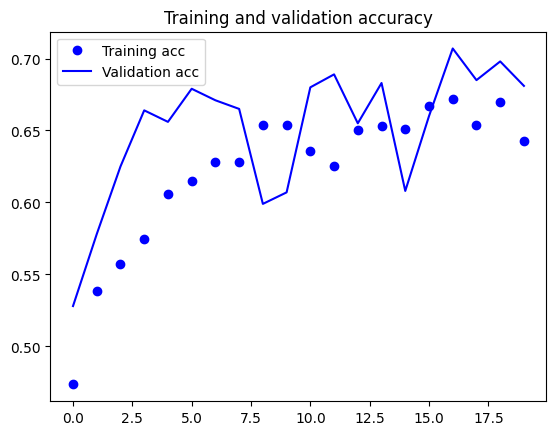

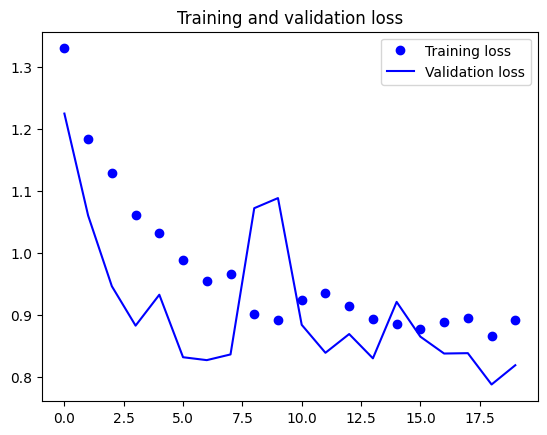

In [30]:
# plot the training and validation scores
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [31]:
# evaludate the model
# Evaluation

eval_test = model.evaluate(test_generator, steps=1000)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - acc: 0.6701 - loss: 1.0040
The test score (accuracy) is 72.69999980926514%


In [32]:
# initiate a pre-trained convolutional base VGG16
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# build the network
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # categorical classification

conv_base.trainable = False
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,069 (72.14 MB)

 Trainable params: 4,197,381 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# configure the model
from keras import optimizers
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer = 'rmsprop',
              metrics=['acc'])

# train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,     
      epochs=5,
      validation_data=valid_generator,
      validation_steps=50       # 1000/20
      )


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - acc: 0.3780 - loss: 2.4418 - val_acc: 0.5550 - val_loss: 1.0996
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - acc: 0.4712 - loss: 1.2233 - val_acc: 0.5880 - val_loss: 0.9921
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - acc: 0.5331 - loss: 1.1197 - val_acc: 0.5970 - val_loss: 0.9808
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - acc: 0.5587 - loss: 1.1014 - val_acc: 0.6030 - val_loss: 0.9485
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - acc: 0.5559 - loss: 1.0856 - val_acc: 0.5990 - val_loss: 0.9422


In [35]:
# evaludate the model
# Evaluation

eval_test = model.evaluate(test_generator, steps=1000)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - acc: 0.7638 - loss: 0.7135
The test score (accuracy) is 79.50000166893005%
